#Deskew the MNIST training and test images


This set of scripts serves several purposes:   
* it provides two functions
    - a function to read the binary MNIST data into numpy.ndarray
    - a function to deskew the data
* it deskews the data and displays the results
* it saves the original and deskewed data plus labels as csv files 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
print cv2.__version__

3.0.0-dev


#OpenCV deskew function

In [2]:
SZ = 28 # images are SZ x SZ grayscale

affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

#Read MNIST binary-file data and convert to numpy.ndarray

thanks to http://g.sweyla.com/blog/2012/mnist-numpy/

In [3]:
import os, struct
from array import array as pyarray 
from numpy import append, array, int8, uint8, zeros

def load_mnist(dataset="training", digits=None, path=None, asbytes=False, selection=None, return_labels=True, return_indices=False):
    """
    Loads MNIST files into a 3D numpy array.

    You have to download the data separately from [MNIST]_. It is recommended
    to set the environment variable ``MNIST`` to point to the folder where you
    put the data, so that you don't have to select path. On a Linux+bash setup,
    this is done by adding the following to your ``.bashrc``::

        export MNIST=/path/to/mnist

    Parameters
    ----------
    dataset : str 
        Either "training" or "testing", depending on which dataset you want to
        load. 
    digits : list 
        Integer list of digits to load. The entire database is loaded if set to
        ``None``. Default is ``None``.
    path : str 
        Path to your MNIST datafiles. The default is ``None``, which will try
        to take the path from your environment variable ``MNIST``. The data can
        be downloaded from http://yann.lecun.com/exdb/mnist/.
    asbytes : bool
        If True, returns data as ``numpy.uint8`` in [0, 255] as opposed to
        ``numpy.float64`` in [0.0, 1.0].
    selection : slice
        Using a `slice` object, specify what subset of the dataset to load. An
        example is ``slice(0, 20, 2)``, which would load every other digit
        until--but not including--the twentieth.
    return_labels : bool
        Specify whether or not labels should be returned. This is also a speed
        performance if digits are not specified, since then the labels file
        does not need to be read at all.
    return_indicies : bool
        Specify whether or not to return the MNIST indices that were fetched.
        This is valuable only if digits is specified, because in that case it
        can be valuable to know how far
        in the database it reached.

    Returns
    -------
    images : ndarray
        Image data of shape ``(N, rows, cols)``, where ``N`` is the number of images. If neither labels nor inices are returned, then this is returned directly, and not inside a 1-sized tuple.
    labels : ndarray
        Array of size ``N`` describing the labels. Returned only if ``return_labels`` is `True`, which is default.
    indices : ndarray
        The indices in the database that were returned.

    Examples
    --------
    Assuming that you have downloaded the MNIST database and set the
    environment variable ``$MNIST`` point to the folder, this will load all
    images and labels from the training set:

    >>> images, labels = ag.io.load_mnist('training') # doctest: +SKIP

    Load 100 sevens from the testing set:    

    >>> sevens = ag.io.load_mnist('testing', digits=[7], selection=slice(0, 100), return_labels=False) # doctest: +SKIP

    """

    # The files are assumed to have these names and should be found in 'path'
    files = {
        'training': ('train-images.idx3-ubyte', 'train-labels.idx1-ubyte'),
        'testing': ('t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte'),
    }

    if path is None:
        try:
            path = os.environ['MNIST']
        except KeyError:
            raise ValueError("Unspecified path requires environment variable $MNIST to be set")

    try:
        images_fname = os.path.join(path, files[dataset][0])
        labels_fname = os.path.join(path, files[dataset][1])
    except KeyError:
        raise ValueError("Data set must be 'testing' or 'training'")

    # We can skip the labels file only if digits aren't specified and labels aren't asked for
    if return_labels or digits is not None:
        flbl = open(labels_fname, 'rb')
        magic_nr, size = struct.unpack(">II", flbl.read(8))
        labels_raw = pyarray("b", flbl.read())
        flbl.close()

    fimg = open(images_fname, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images_raw = pyarray("B", fimg.read())
    fimg.close()

    if digits:
        indices = [k for k in range(size) if labels_raw[k] in digits]
    else:
        indices = range(size)

    if selection:
        indices = indices[selection] 
    N = len(indices)

    images = zeros((N, rows, cols), dtype=uint8)

    if return_labels:
        labels = zeros((N), dtype=int8)
    for i, index in enumerate(indices):
        images[i] = array(images_raw[ indices[i]*rows*cols : (indices[i]+1)*rows*cols ]).reshape((rows, cols))
        if return_labels:
            labels[i] = labels_raw[indices[i]]

    if not asbytes:
        images = images.astype(float)/255.0

    ret = (images,)
    if return_labels:
        ret += (labels,)
    if return_indices:
        ret += (indices,)
    if len(ret) == 1:
        return ret[0] # Don't return a tuple of one
    else:
        return ret

#Training Data

##Read in the training images and labels

In [4]:
images, labels = load_mnist('training', path="/home/george/Dropbox/MNIST/data")

##Deskew training data

In [5]:
images_deskewed = np.empty(np.shape(images))
i = 0

for img in images:
    images_deskewed[i] = deskew(np.reshape(img,(28,28)))
    i+=1

##Show a sampling of training images before and after deskewing

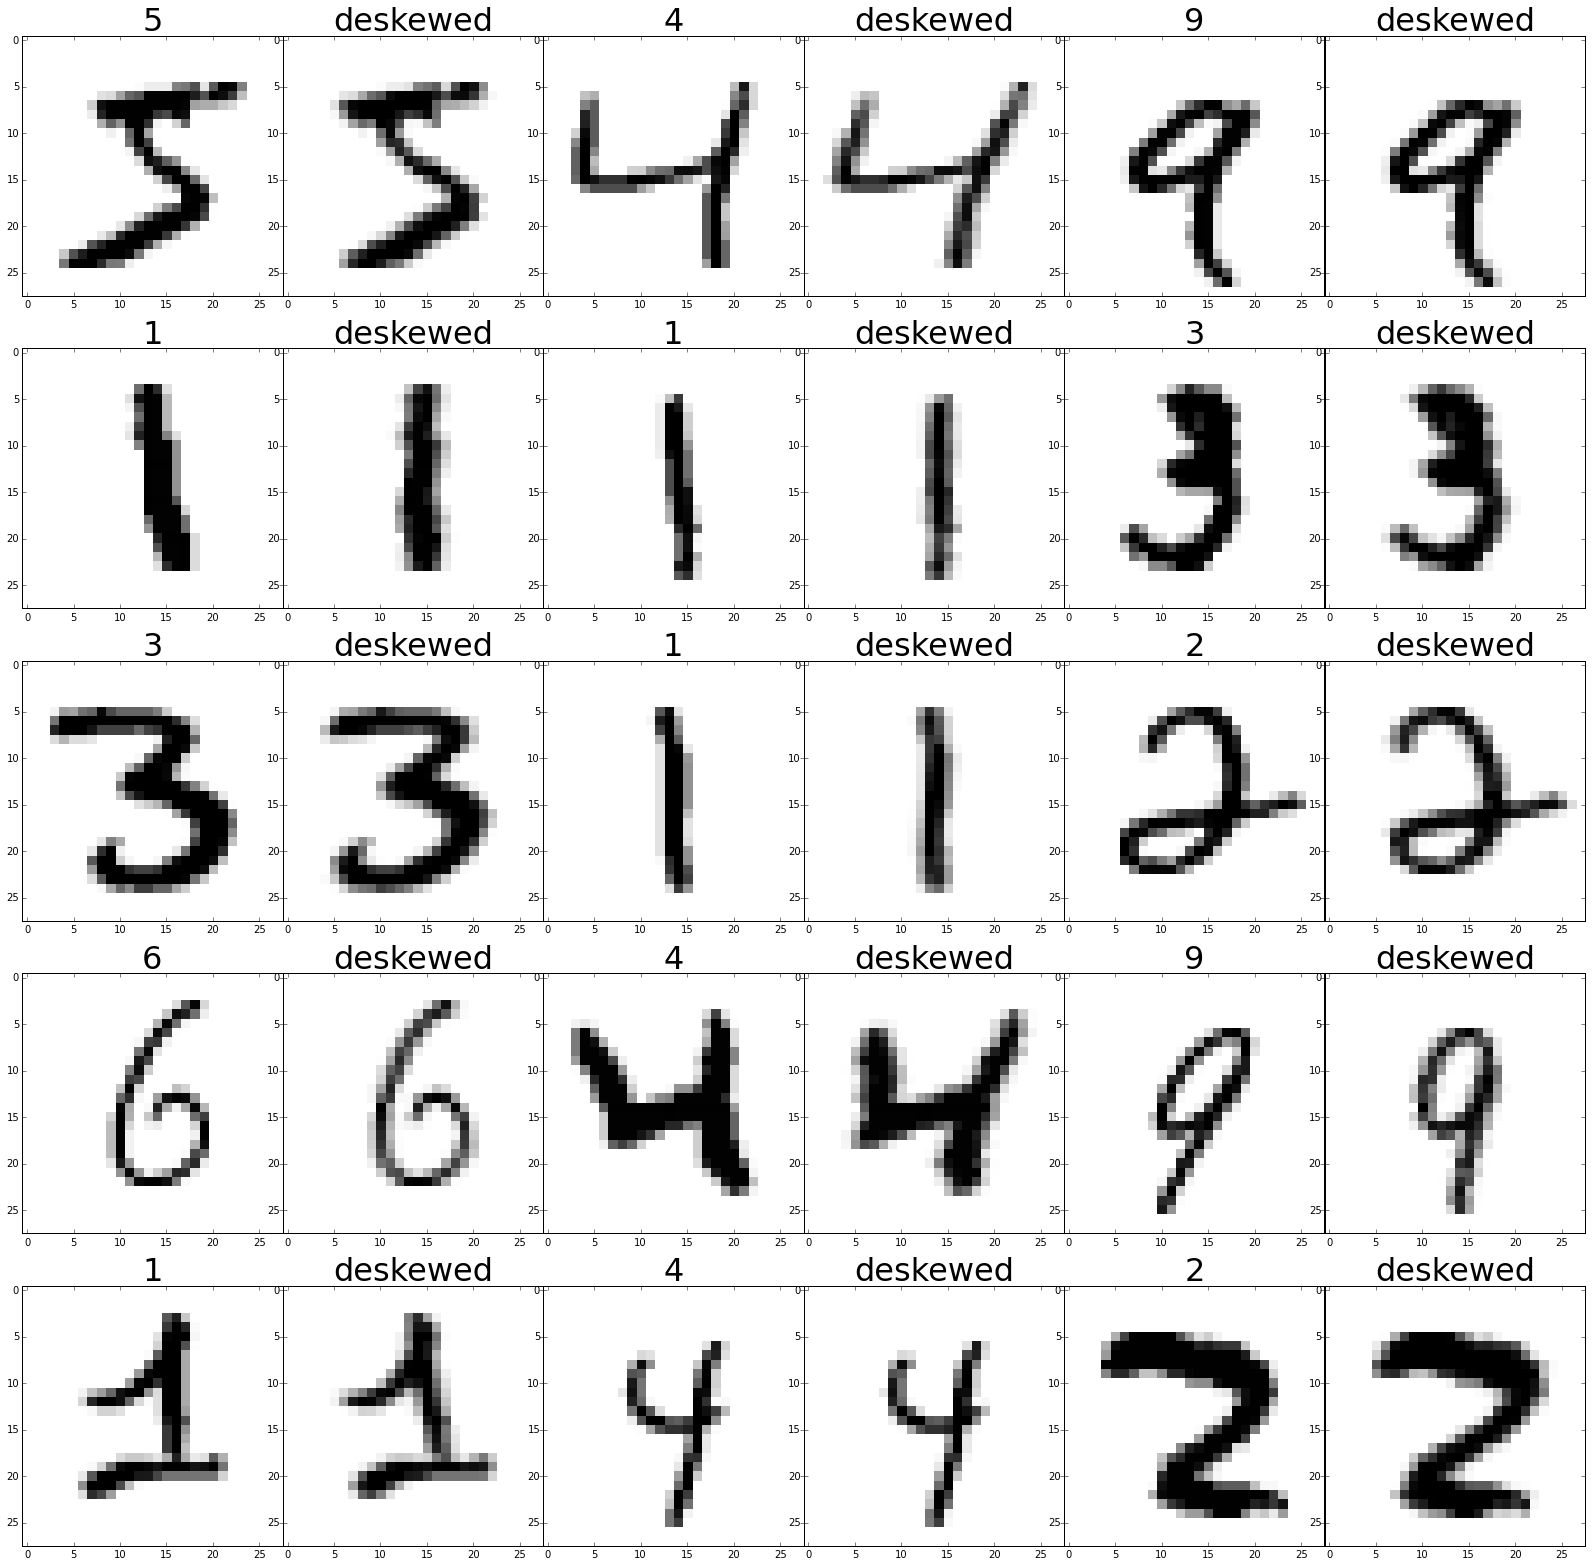

In [6]:
fig, axs = plt.subplots(5,6, figsize=(28,28), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0001, wspace=.001)

axs = axs.ravel()

for i in range(0,30,2):
    
    # convert from 1 x 784 to 28 x 28
    img     = np.reshape(images[i,:],(28,28))
    img_dsk = np.reshape(images_deskewed[i,:],(28,28))
    
    axs[i].imshow(img,cmap=plt.cm.gray_r, interpolation='nearest')
    axs[i].set_title(labels[i],fontsize=32)
    
    axs[i+1].imshow(img_dsk,cmap=plt.cm.gray_r, interpolation='nearest')
    axs[i+1].set_title('deskewed',fontsize=32)
    
plt.show()

##Save training data to csv

In [7]:
import csv
with open('data/train-images.csv', 'wb') as f:
    csv.writer(f).writerows([img.flatten() for img in images])
with open('data/train-labels.csv', 'wb') as f:
    csv.writer(f).writerows([label.flatten() for label in labels])
    
with open('data/train-images_deskewed.csv', 'wb') as f:
    csv.writer(f).writerows([img.flatten() for img in images_deskewed])

#Test Data

In [8]:
images = None
labels = None
images_deskewed = None

##Read in the test images and labels

In [9]:
images, labels = load_mnist('testing', path="/home/george/Dropbox/MNIST/data")

##Deskew test data

In [10]:
images_deskewed = np.empty(np.shape(images))
i = 0

for img in images:
    images_deskewed[i] = deskew(np.reshape(img,(28,28)))
    i+=1

##Show a sampling of test images before and after deskewing

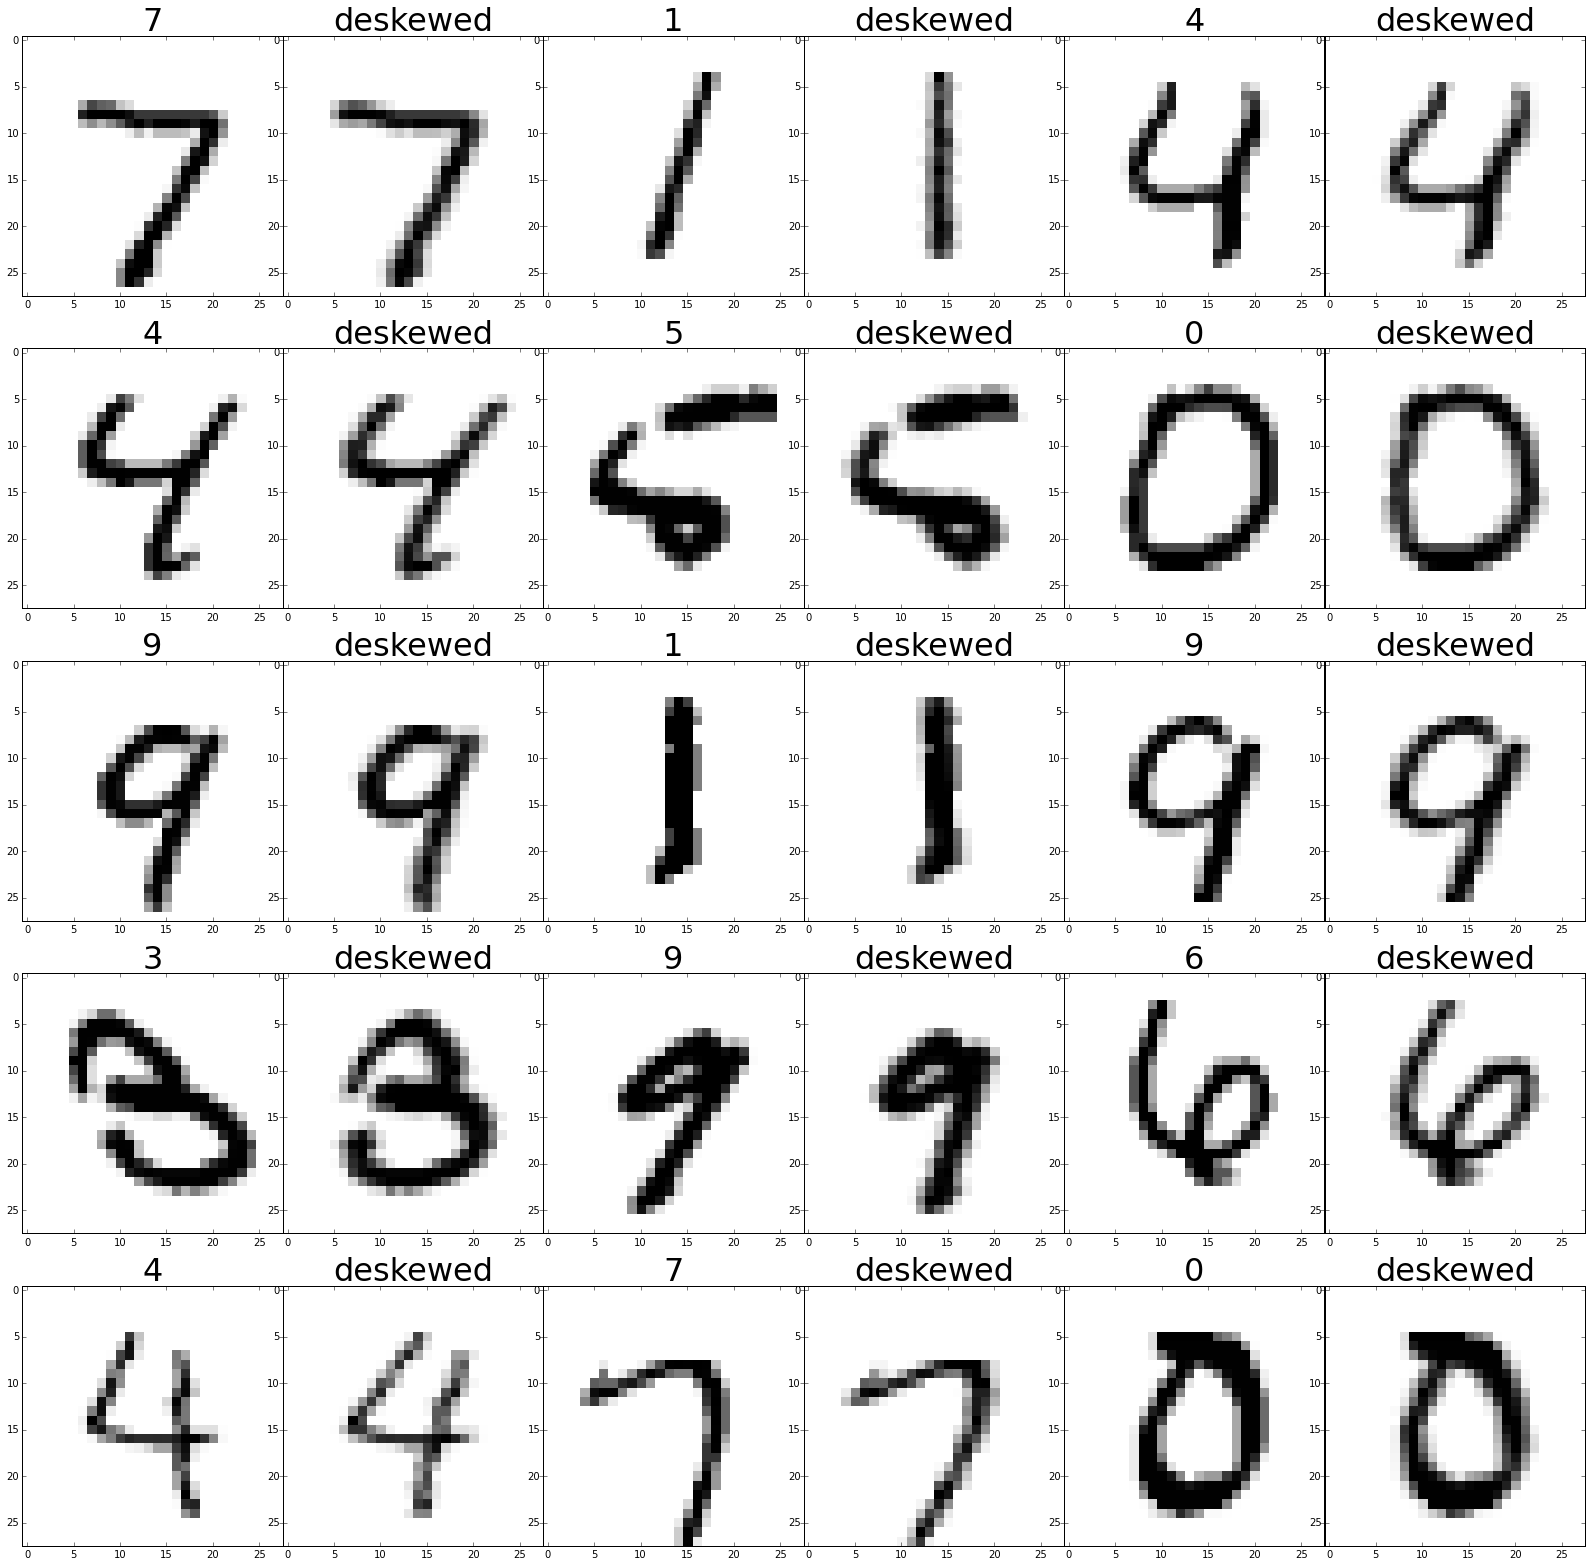

In [11]:
fig, axs = plt.subplots(5,6, figsize=(28,28), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0001, wspace=.001)

axs = axs.ravel()

for i in range(0,30,2):
    
    # convert from 1 x 784 to 28 x 28
    img     = np.reshape(images[i,:],(28,28))
    img_dsk = np.reshape(images_deskewed[i,:],(28,28))
    
    axs[i].imshow(img,cmap=plt.cm.gray_r, interpolation='nearest')
    axs[i].set_title(labels[i],fontsize=32)
    
    axs[i+1].imshow(img_dsk,cmap=plt.cm.gray_r, interpolation='nearest')
    axs[i+1].set_title('deskewed',fontsize=32)
    
plt.show()

##Save test data to csv

In [12]:
import csv
with open('data/t10k-images.csv', 'wb') as f:
    csv.writer(f).writerows([img.flatten() for img in images])
with open('data/t10k-labels.csv', 'wb') as f:
    csv.writer(f).writerows([label.flatten() for label in labels])
    
with open('data/t10k-images_deskewed.csv', 'wb') as f:
    csv.writer(f).writerows([img.flatten() for img in images_deskewed])